In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
train_data = pd.read_csv('Q3_train.csv')
train_images = torch.tensor(train_data.drop('label', axis=1).values)
train_labels = torch.tensor(train_data['label'].values)
test_data = pd.read_csv('Q3_test.csv')
test_images = torch.tensor(test_data.drop('label', axis=1).values)
test_labels = torch.tensor(test_data['label'].values)

C:\Users\mhme2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


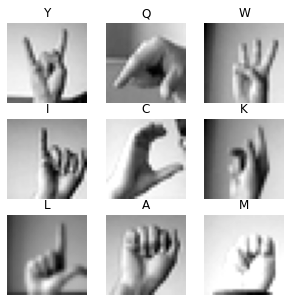

In [2]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'X', 'Y']
plt.figure(figsize=(5,5))
for i in range(9):
    j=np.random.randint(0,train_images.shape[0])
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[j].reshape(28,28), cmap='gray')
    plt.title( alphabet[ train_labels[j].item() ] )
    plt.axis('off')
plt.show()

In [3]:
class customDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

train_dataset = customDataset(train_images, train_labels)
test_dataset = customDataset(test_images, test_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [4]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Linear(150, 70),
            nn.BatchNorm1d(70),
            nn.ReLU(),
            nn.Linear(70, 26)
        )
    def forward(self, x):
        x = self.layer_stack(x)
        x = torch.softmax(x, dim=1)
        return x
simple_model_SGD = NN()
simple_model_Adam = NN()

In [5]:
def train_loop(data_loader, model, optimizer, loss_fn):
    size = len(data_loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X = X.float()
        y = y.long()
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"gradient mean= {model.layer_stack[0].weight.grad.mean()}")

def test_loop(model, loss_fn, test_losses, train_losses):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, correct, train_loss = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.float()
            y = y.long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    test_loss, correct, train_loss = 0, 0, 0
    with torch.no_grad():
        for X, y in train_dataloader:
            X = X.float()
            y = y.long()
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    train_losses.append(train_loss)
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

Epoch 1
-----------------------------
loss: 3.257147  [    0/27455]
gradient mean= 1.7414018657291308e-05
loss: 3.249313  [ 6400/27455]
gradient mean= -1.2173792129033245e-05
loss: 3.188686  [12800/27455]
gradient mean= -3.349485996295698e-05
loss: 3.151005  [19200/27455]
gradient mean= -8.821204392006621e-05
loss: 3.122405  [25600/27455]
gradient mean= -6.914819823578e-05
Test Error: 
 Accuracy: 20.8%, Avg loss: 3.153801 

Train Error: 
 Accuracy: 28.4%, Avg loss: 3.107955 

Epoch 2
-----------------------------
loss: 3.174323  [    0/27455]
gradient mean= 3.016987830051221e-05
loss: 3.023911  [ 6400/27455]
gradient mean= 1.4607557204726618e-05
loss: 3.030168  [12800/27455]
gradient mean= -5.055803922004998e-05
loss: 3.015961  [19200/27455]
gradient mean= -2.3076176148606464e-05
loss: 3.047846  [25600/27455]
gradient mean= 2.9065698981867172e-05
Test Error: 
 Accuracy: 32.1%, Avg loss: 3.089773 

Train Error: 
 Accuracy: 41.1%, Avg loss: 2.979477 

Epoch 3
----------------------------

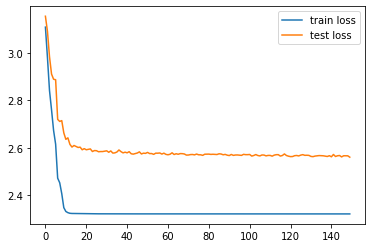

In [6]:
epochs = 150
optimizer = torch.optim.SGD(simple_model_SGD.parameters(), lr=3e-2)
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    train_loop(train_dataloader, simple_model_SGD, optimizer, loss_fn)
    test_loop(simple_model_SGD, loss_fn, test_losses, train_losses)
print("Done!")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

Epoch 1
-----------------------------
loss: 3.258813  [    0/27455]
gradient mean= 8.746817002247553e-06
loss: 2.982475  [ 6400/27455]
gradient mean= -2.0948145902366377e-05
loss: 2.927320  [12800/27455]
gradient mean= -3.512855255394243e-05
loss: 2.682502  [19200/27455]
gradient mean= -0.0001362572656944394
loss: 2.594649  [25600/27455]
gradient mean= -5.398034045356326e-05
Test Error: 
 Accuracy: 52.4%, Avg loss: 2.905083 

Train Error: 
 Accuracy: 61.5%, Avg loss: 2.830707 

Epoch 2
-----------------------------
loss: 2.599598  [    0/27455]
gradient mean= -7.266447937581688e-05
loss: 2.459844  [ 6400/27455]
gradient mean= -3.584342630347237e-05
loss: 2.389660  [12800/27455]
gradient mean= -7.000588084338233e-05
loss: 2.374947  [19200/27455]
gradient mean= 6.385258893715218e-05
loss: 2.349891  [25600/27455]
gradient mean= -6.034233229001984e-05
Test Error: 
 Accuracy: 39.9%, Avg loss: 2.947018 

Train Error: 
 Accuracy: 57.2%, Avg loss: 2.787764 

Epoch 3
---------------------------

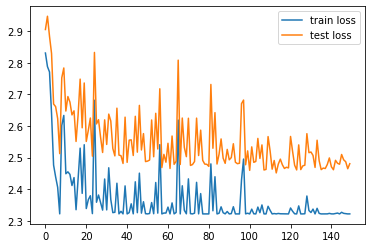

In [7]:
epochs = 150
optimizer = torch.optim.Adam(simple_model_Adam.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    train_loop(train_dataloader, simple_model_Adam, optimizer, loss_fn)
    test_loop(simple_model_Adam, loss_fn, test_losses, train_losses)
print("Done!")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

Adam algorithm uses a moving average of the gradient and the squared gradient, which are used to scale the learning rate for each weight. This is done to avoid the problem of the learning rate being too high for some weights and too low for others. The moving average of the gradient is used to scale the learning rate for the weights, while the moving average of the squared gradient is used to scale the momentum term. The momentum term is used to help the algorithm escape saddle points and other local minima in the loss function.
it seems that the Adam algorithm is converging faster in the beginning, but then it starts to bounce up and down around the minimum.
the final result of Adam is a little better than the result of SGD.

In [8]:
class Drop_NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(256, 200),
            nn.BatchNorm1d(200),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(150, 70),
            nn.BatchNorm1d(70),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(70, 26)
        )
    def forward(self, x):
        x = self.layer_stack(x)
        x = torch.softmax(x, dim=1)
        return x
Dropout_model_Adam = Drop_NN()

Epoch 1
-----------------------------
loss: 3.257494  [    0/27455]
gradient mean= 2.2503883883473463e-05
loss: 3.251421  [ 6400/27455]
gradient mean= -1.6097237676149234e-05
loss: 3.250025  [12800/27455]
gradient mean= 1.2473223023334867e-06
loss: 3.247589  [19200/27455]
gradient mean= -3.686263517010957e-05
loss: 3.222624  [25600/27455]
gradient mean= 1.385139057674678e-05
Test Error: 
 Accuracy: 20.4%, Avg loss: 3.229450 

Train Error: 
 Accuracy: 20.0%, Avg loss: 3.218341 

Epoch 2
-----------------------------
loss: 3.235989  [    0/27455]
gradient mean= 4.543461909634061e-05
loss: 3.235053  [ 6400/27455]
gradient mean= -4.3778571125585586e-05
loss: 3.202783  [12800/27455]
gradient mean= -1.283835263166111e-05
loss: 3.181334  [19200/27455]
gradient mean= -2.5091150746447966e-05
loss: 3.149372  [25600/27455]
gradient mean= -4.584563794196583e-05
Test Error: 
 Accuracy: 24.4%, Avg loss: 3.139234 

Train Error: 
 Accuracy: 25.2%, Avg loss: 3.135283 

Epoch 3
-------------------------

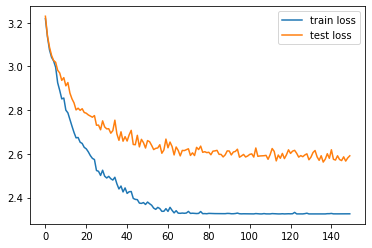

In [9]:
epochs = 150
optimizer = torch.optim.Adam(Dropout_model_Adam.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    train_loop(train_dataloader, Dropout_model_Adam, optimizer, loss_fn)
    test_loop(Dropout_model_Adam, loss_fn, test_losses, train_losses)
print("Done!")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

the droput technique is supposed to help the model generalize better, but it seems that it is making the model worse and it is exacerbating the problem of overfitting.

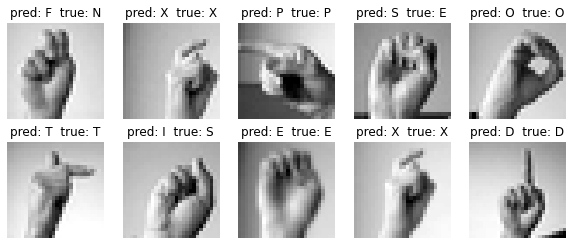

In [77]:
plt.figure(figsize=(10,4))
for i in range(530,540):
    x , y=test_images[i] , test_labels[i]
    plt.subplot(2,5,i-529)
    plt.imshow(x.reshape(28,28),cmap='gray')
    x=x.reshape(1,784)
    pred = simple_model_Adam(x.float())
    plt.title("pred: "+str( alphabet[ torch.argmax(pred) ])+"  true: "+str( alphabet[ y.item() ] ) )
    plt.axis('off')
plt.show()

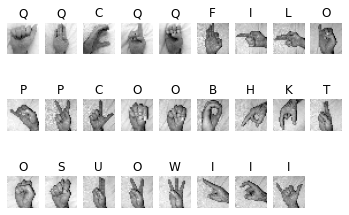

In [69]:
simple_model_Adam.eval()
import cv2 as cv
for i in range(26):
    s = str(i+1)
    img = cv.imread("./my_images/"+s+".jpg")
    img=img.mean(axis=2)
    img = cv.resize(img,dsize=(28,28))
    plt.subplot(3,9,i+1)
    plt.imshow(img,cmap='gray')
    x = torch.from_numpy(img)
    x=x.reshape(1,784)
    pred = simple_model_Adam(x.float())
    plt.title(str( alphabet[ torch.argmax(pred) ] ) )
    plt.axis('off')
plt.show()